In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [2]:
df = pd.read_csv('../data/final_dataset.csv', dtype=np.float32)
df.describe()

,date,open,high,low,close,volume
count,74456.000000,74456.000000,74456.000000,74456.000000,74456.000000,7.445600e+04
mean,1551.727539,17561.365234,17645.437500,17472.281250,17562.277344,1.350327e+06
std,895.626648,17444.687500,17530.435547,17353.238281,17445.542969,2.814597e+06
min,1.000000,0.000000,243.600006,0.000000,243.600006,0.000000e+00
25%,776.000000,3893.802551,3909.609924,3879.997498,3893.919983,1.060162e+05
50%,1552.000000,9674.774902,9720.584961,9626.750000,9675.180176,4.637802e+05
75%,2327.000000,28517.881836,28623.537109,28411.072754,28521.245117,1.442926e+06
max,3103.000000,73612.773438,73797.679688,73260.343750,73612.773438,1.039629e+08


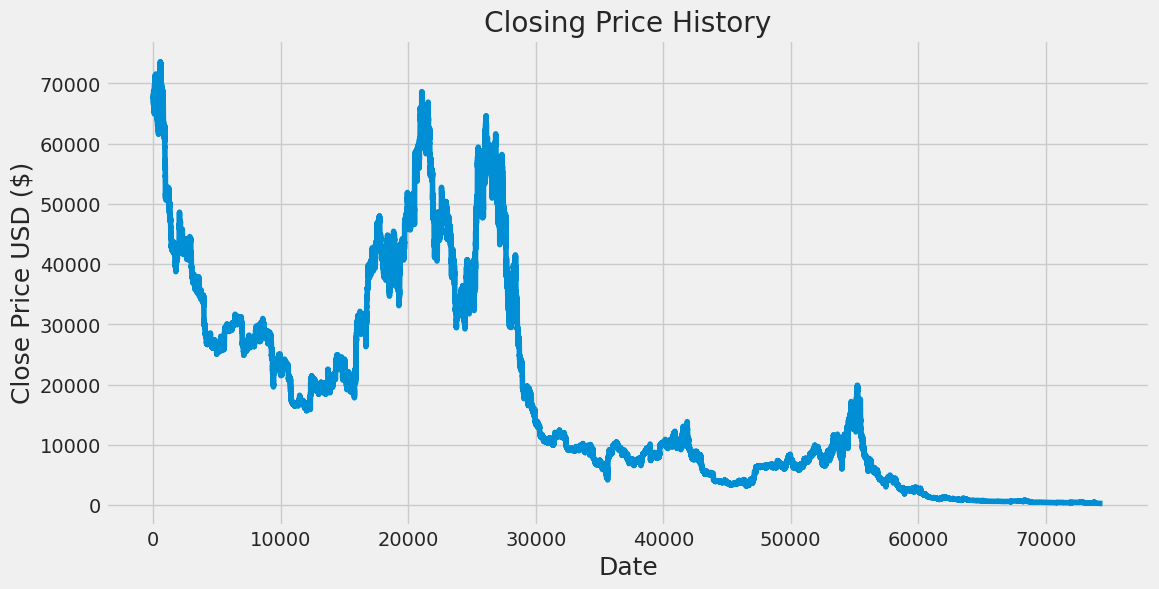

In [3]:
# Historical view of closing price
plt.figure(figsize=(12, 6))
plt.title('Closing Price History')
plt.plot(df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

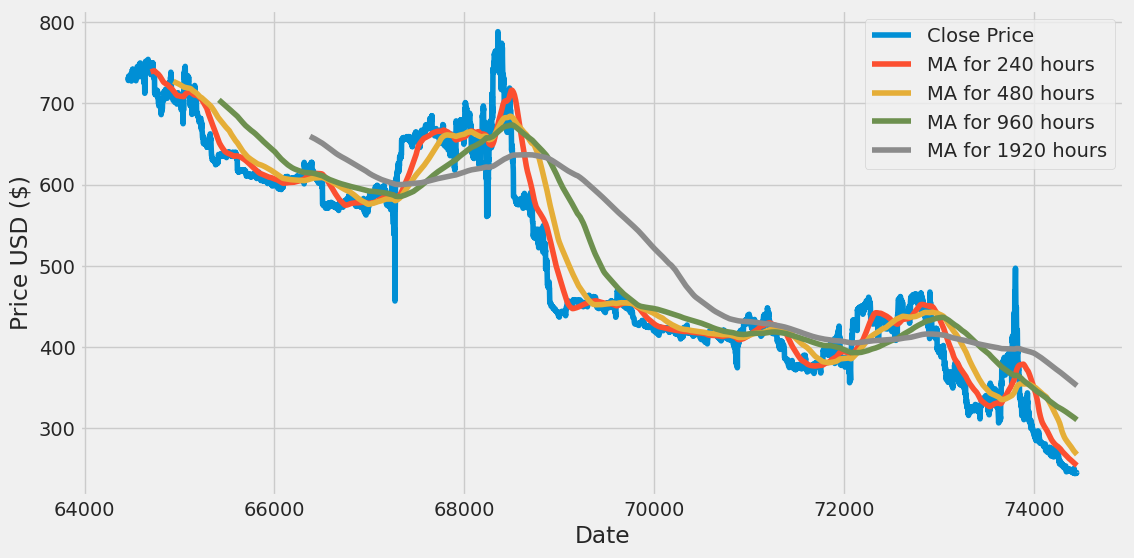

In [4]:
# Assuming df is your DataFrame containing Bitcoin price data
latest_entries_df = df.iloc[-10000:]

# Moving averages for 10 day, 20 days, 40 days, 80 days
ma_day = [240, 480, 960, 1920]
moving_averages = {}  # Dictionary to store moving averages

# Calculate moving averages
for ma in ma_day:
    column_name = f"MA for {ma} hours"
    moving_averages[column_name] = latest_entries_df['close'].rolling(window=ma).mean()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(latest_entries_df['close'], label='Close Price')

# Plotting moving averages
for ma, ma_values in moving_averages.items():
    ax.plot(ma_values, label=ma)

ax.set_xlabel('Date')
ax.set_ylabel('Price USD ($)')
ax.legend()
plt.show()


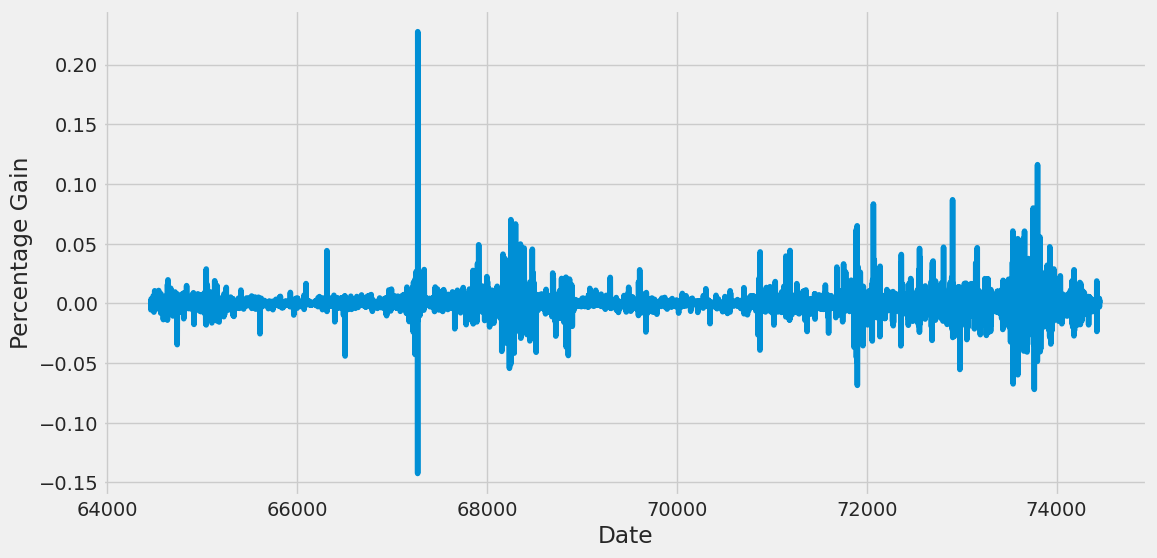

In [5]:
# Find percentage gains for each day
# Each day has the same date number
daily_return = latest_entries_df['close'] / latest_entries_df['close'].shift(1) - 1
daily_return = daily_return[1:]  # Remove first entry as it is NaN

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_return)
ax.set_xlabel('Date')
ax.set_ylabel('Percentage Gain')
plt.show()

## Predictions

In [6]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # Input features
        y.append(data[i+seq_length, -1])     # Target (close price)
    return np.array(X), np.array(y)

In [7]:
features = ['open', 'high', 'low', 'volume']
target = 'close'

data = df[features + [target]].values

# Normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

SEQUENCE_LENGTH = 24

# Create sequences
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
training_data_len = len(X_train)

print(X_train.shape, y_train.shape)

(59545, 24, 4) (59545,)


In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

2024-04-06 18:21:34.763856: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-06 18:21:34.766829: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-06 18:21:34.806397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 18:21:35.730865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-06 18:21:36.379570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

59545/59545 ━━━━━━━━━━━━━━━━━━━━ 516s 9ms/step - loss: 2.7741e-04


In [16]:
model.save('lstm_model.keras')

In [23]:
# Get the models predicted price values
predictions = model.predict(X_test)

# Unscale the data
mm_scaller_pred = MinMaxScaler()
mm_scaller_pred.min_, mm_scaller_pred.scale_ = scaler.min_[3], scaler.scale_[3]

predictions = mm_scaller_pred.inverse_transform(predictions)

466/466 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


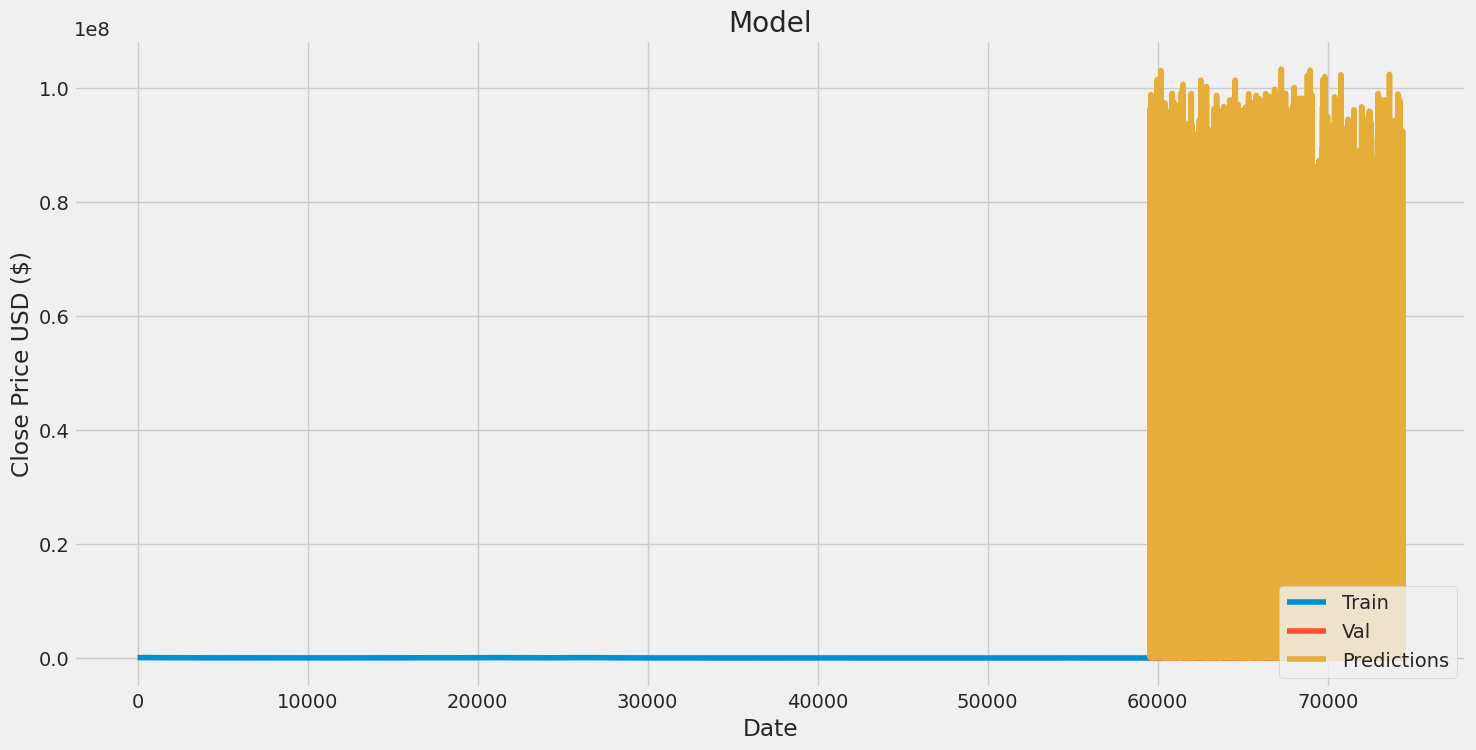

In [30]:
# Visualize the data
train = df[training_data_len - 1000:training_data_len]
valid = df[training_data_len:]

# Adjust the length of the valid DataFrame to match predictions
valid = valid[:len(predictions)]

# Create DataFrame for predictions with correct index
valid_index = df.index[training_data_len:][:len(predictions)]
valid['Predictions'] = pd.Series(predictions[:,0], index=valid_index)

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()